In [7]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Creating the Spark session and ContextRun PySpark.
conf = SparkConf().set("spark.ui.port","4050")
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.appName("Clustering").config('spark.ui.port', '4050').getOrCreate()
spark

In [128]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import random
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from sklearn.metrics import silhouette_score
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.mllib.clustering import BisectingKMeans
from pyspark.ml.clustering import KMeans
from math import sqrt
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.metrics import  mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D



In [3]:

clusteringDF = spark.read.csv("scaled_data_allCols.csv", header=True, inferSchema=True)

In [5]:
# Calculating correlation of yield with other columns

columns = clusteringDF.columns
correlation = {}

for column in columns:
    correlation["Yield"+","+column] = clusteringDF.corr(column,"Yield")
    
correlation = dict(sorted(correlation.items(), key=lambda item: item[1], reverse=True))
for key,value in correlation.items():
    print(key + " : " + str(value))

Yield,Yield : 1.0
Yield,Production : 0.4133689060779217
Yield,Season : 0.30601323742250097
Yield,Crop_Year : 0.08374795645349611
Yield,Fertilizer : 0.07928871314219924
Yield,Pesticide : 0.07817952592704037
Yield,Crop : 0.07203904181289146
Yield,Area : 0.07182547828747035
Yield,Annual_Rainfall : 0.019347997819223525
Yield,State : 0.009421130560306044


In [6]:
# Vector Assembler

input_cols = ['Yield','Production','Season']
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol="features")
final_data = vec_assembler.transform(clusteringDF)

In [131]:
# Function to visualize the clusters

def plotCbisecting(predictions,K):
    X = predictions.select("Yield").rdd.flatMap(lambda x: x).collect()
    Y = predictions.select("Production").rdd.flatMap(lambda x: x).collect()
    Z = predictions.select("Season").rdd.flatMap(lambda x: x).collect()  # Assuming you have a 'Z' column for 3D plotting
    cluster_labels = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X, Y, Z, c=cluster_labels, cmap='viridis', edgecolor='k', s=50)
    ax.set_title('K = ' + str(K))
    ax.set_xlabel('Yield')
    ax.set_ylabel('Production')
    ax.set_zlabel('Season')
    ax.grid(True)
    ax.legend(title='Cluster')

    plt.show()



In [ ]:
# Function to calculate the BCSS

def calculateBcss(clusterCenters):

    bsse = 0.0

    num = len(clusterCenters)


    for i in range(num):

        for j in range(num):

          if(i!=j):

            centeri = clusterCenters[i]

            centerj = clusterCenters[j]

            squaredDist = np.sum((centeri - centerj) ** 2)

            bsse = bsse + squaredDist


    return bsse

# K = 3

In [115]:
# Fitting the model

kmeans1 = KMeans(featuresCol='features',k=3)
model1 = kmeans1.fit(final_data)

In [117]:
# Printing cluster centroids

centroids1 = model1.clusterCenters()

for i, centroid in enumerate(centroids1):
    print(f"Centroid for Cluster {i+1}: {centroid}")

Centroid for Cluster 1: [0.63709001 0.13533916 3.95132275]
Centroid for Cluster 2: [-0.45166285 -0.59533812  1.44226401]
Centroid for Cluster 3: [0.49562868 1.49441728 1.40737933]


In [118]:
# Printing the number of data points within each cluster

model1.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|11007|
|         2| 3957|
|         0| 4725|
+----------+-----+



In [120]:
# Calculating the Silhouette Score

predictions1=model1.transform(final_data)
evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette1 = evaluator.evaluate(predictions1)
print(silhouette1)

0.624376080784778


In [121]:
# Calculating the WCSS

model1.summary.trainingCost

28065.087682200214

In [122]:
# Calculating the BCSS

calculateBcss(centroids1)

43.23811292414575

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


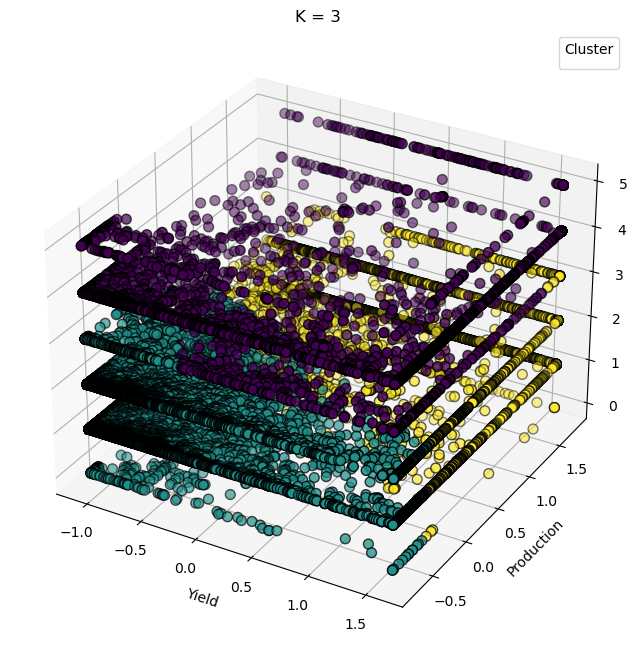

In [132]:
# Visualizing the clusters

plotCbisecting(predictions1,3)

# K = 5

In [60]:
# Fitting the model

kmeans2 = KMeans(featuresCol='features',k=5)
model2 = kmeans2.fit(final_data)

In [41]:
# Printing cluster centroids

centroids2 = model2.clusterCenters()

for i, centroid in enumerate(centroids2):
    print(f"Centroid for Cluster {i+1}: {centroid}")

Centroid for Cluster 1: [1.34893237 1.64358697 3.95892169]
Centroid for Cluster 2: [-0.50591819 -0.59375849  1.36450512]
Centroid for Cluster 3: [ 1.42497265 -0.41895242  3.33460986]
Centroid for Cluster 4: [0.41156477 1.54144321 1.30060841]
Centroid for Cluster 5: [-0.63492937 -0.53909821  3.81575311]


In [42]:
# Printing the number of data points within each cluster

model2.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|10255|
|         3| 3616|
|         4| 2171|
|         2| 2089|
|         0| 1558|
+----------+-----+



In [44]:
# Calculating the Silhouette Score

predictions2=model2.transform(final_data)
silhouette2 = evaluator.evaluate(predictions2)
print(silhouette2)

0.6669725824067133


In [45]:
# Calculating the WCSS

model2.summary.trainingCost

17459.67510038815

In [46]:
# Calculating the BCSS

calculateBcss(centroids2)

161.64486943801109

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


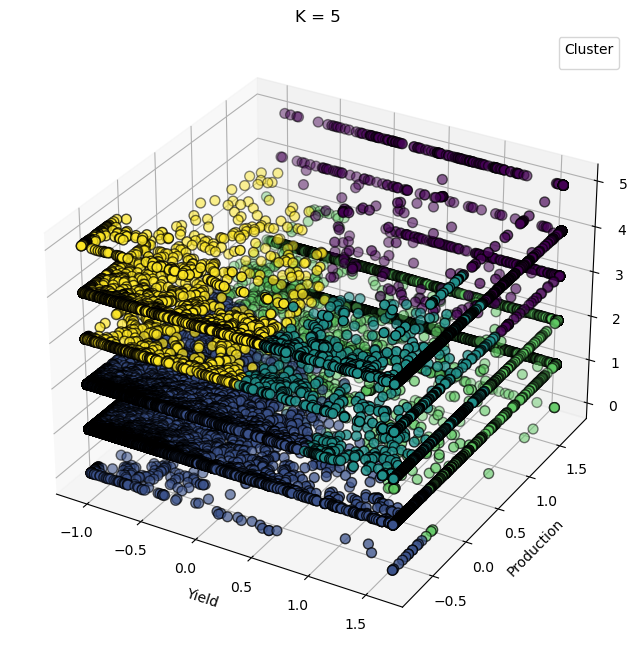

In [133]:
# Visualizing the clusters

plotCbisecting(predictions2,5)

# K = 15

In [105]:
# Fitting the model

kmeans3 = KMeans(featuresCol='features',k=15)
model3 = kmeans3.fit(final_data)

In [107]:
# Printing cluster centroids

centroids3 = model3.clusterCenters()

for i, centroid in enumerate(centroids3):
    print(f"Centroid for Cluster {i+1}: {centroid}")

Centroid for Cluster 1: [-0.80284844 -0.62744803  2.        ]
Centroid for Cluster 2: [1.20854181 1.67984224 0.91462113]
Centroid for Cluster 3: [-0.82503929 -0.62373353  5.        ]
Centroid for Cluster 4: [ 1.46393214 -0.43068765  0.95966785]
Centroid for Cluster 5: [ 1.47877391 -0.28633538  2.08899676]
Centroid for Cluster 6: [-0.38886578  1.58782632  1.31356369]
Centroid for Cluster 7: [ 1.56746411 -0.44685072  3.94264943]
Centroid for Cluster 8: [ 0.03836443 -0.50674462  2.        ]
Centroid for Cluster 9: [-0.17213301 -0.5463741   0.95810364]
Centroid for Cluster 10: [-0.13391884  1.32777199  4.04529617]
Centroid for Cluster 11: [1.57554437 1.68261516 4.0887522 ]
Centroid for Cluster 12: [-0.88858083 -0.62321007  0.96129542]
Centroid for Cluster 13: [1.28247352 1.62185692 2.30235602]
Centroid for Cluster 14: [ 0.30972944 -0.53722447  3.48636364]
Centroid for Cluster 15: [-0.80551338 -0.59746371  3.74113009]


In [108]:
# Printing the number of data points within each cluster

model3.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|        12|  765|
|         1|  937|
|        13|  659|
|         6| 1197|
|         3|  843|
|         5| 1936|
|         9|  288|
|         4|  657|
|         8| 1818|
|         7|  993|
|        10| 1139|
|        11| 3796|
|        14| 1521|
|         2|  170|
|         0| 2970|
+----------+-----+



In [110]:
# Calculating the Silhouette Score

predictions3=model3.transform(final_data)
silhouette3 = evaluator.evaluate(predictions3)
print(silhouette3)

0.6110852980734572


In [111]:
# Calculating the WCSS

model3.summary.trainingCost

5266.884735190327

In [112]:
# Calculating the BCSS

calculateBcss(centroids3)

1687.6775740968012

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


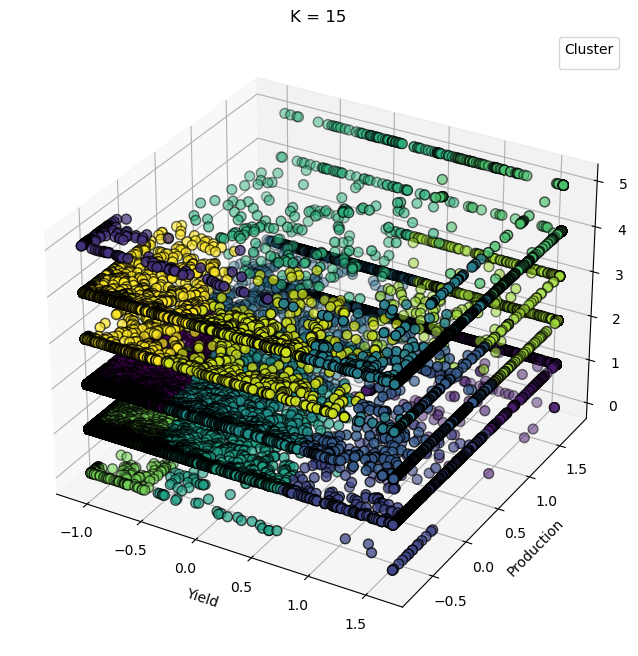

In [134]:
# Visualizing the clusters

plotCbisecting(predictions3,15)

In [8]:
sc.stop()